#### authors: Rafael Dousse, Eva Ray, Massimo Stefani

# Practical work 08 - Clustering

## Imports

In [1]:
import _pickle as pickle
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

## Exercise 1 - Getting the data

a) Load the two given datasets:

In [2]:
data1, label1 = pickle.load(open("dataset_1.pkl", "rb"), encoding ="latin1")
data2, label2 = pickle.load(open("dataset_2.pkl", "rb"), encoding ="latin1")

In [3]:
data1

array([[ 0.95144703,  0.57998206],
       [ 3.76405235,  2.40015721],
       [-4.49579549, -2.78342229],
       ...,
       [-2.39288833,  2.95182959],
       [-1.36840257,  4.37775917],
       [-4.97240289, -2.65377893]], shape=(1000, 2))

In [4]:
label2

array([1, 1, 3, ..., 3, 2, 1], shape=(3000,))

In [5]:
## Normalize datasets
from sklearn.discriminant_analysis import StandardScaler


scaler = StandardScaler()
data1 = scaler.fit_transform(data1)
data2 = scaler.fit_transform(data2)

In [6]:
data1

array([[ 0.95444721, -0.02233829],
       [ 1.97276906,  0.4981735 ],
       [-1.017762  , -0.9841642 ],
       ...,
       [-0.25639093,  0.65593413],
       [ 0.11453073,  1.06370431],
       [-1.19032078, -0.94709035]], shape=(1000, 2))

b) Visualize the data using various color for each unique labels

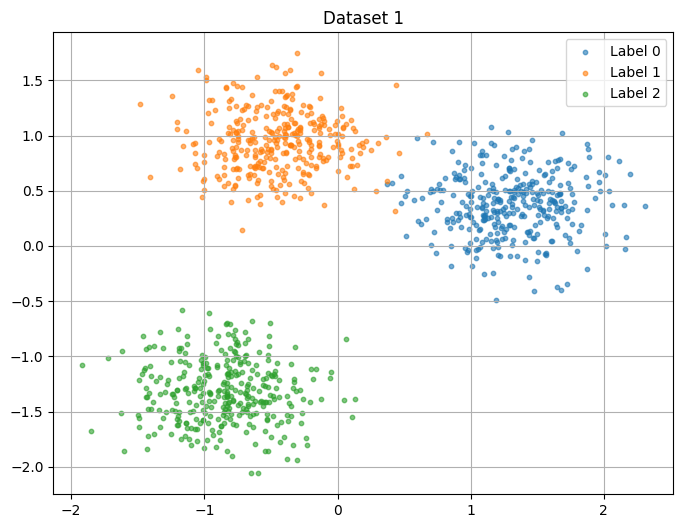

In [7]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(label1)
for lbl in unique_labels:
    plt.scatter(data1[label1 == lbl, 0], data1[label1 == lbl, 1], label=f'Label {lbl}', s=10, alpha=0.6)
plt.title('Dataset 1')
plt.grid()
plt.legend()
plt.show()

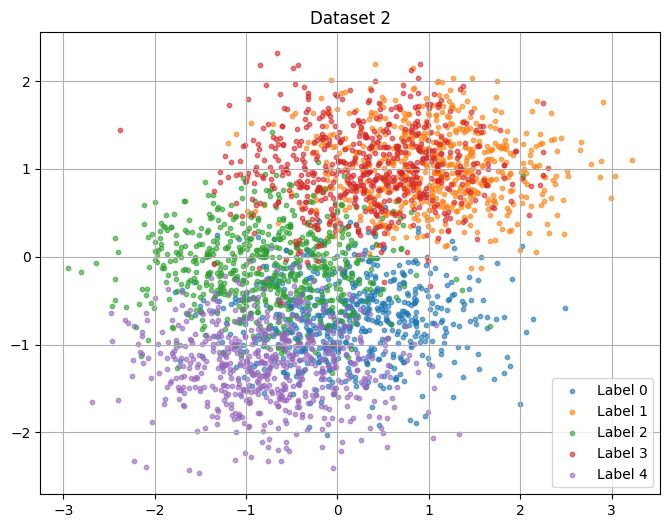

In [8]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(label2)
for lbl in unique_labels:
    plt.scatter(data2[label2 == lbl, 0], data2[label2 == lbl, 1], label=f'Label {lbl}', s=10, alpha=0.6)
plt.title('Dataset 2')
plt.grid()
plt.legend()
plt.show()

## Exercise 2 - The $k$-means algorithm

a) Initialise the centroids $\mu_1, \mu_2, ... , \mu_K$

In [9]:
def initialise_centroids(data, k, seed=13):
    """
    Initialise k centroids by randomly selecting k unique samples from the data.
    Parameters:
        - data: numpy array of shape (n_samples, n_features)
        - k: number of centroids
        - seed: random seed for reproducibility
    Returns:
        - centroids: numpy array of shape (k, n_features)
    """
    np.random.seed(seed)
    nb_samples = data.shape[0]
    return data[np.random.choice(nb_samples, k, replace=False)]

b) Until convergence :

<span style="margin-left: 20px;">i) Find the closest centroid for each point</span>

In [10]:
# We choose to use the Euclidean distance
def find_closest_centroids(data, codebook):
    """"
    Find the index of the closest centroid for each sample in the data.
    Parameters:
        - data: numpy array of shape (n_samples, n_features)
        - codebook: numpy array of shape (k, n_features) representing the centroids
    Returns:
        - closest_centroids: numpy array of shape (n_samples,) representing the index of the closest centroid for each sample
    """
    distances = []
    for sample in data:
        # linalg.norm computes the norm of a vector, here we compute the norm between the sample and each centroid, which
        # gives us the euclidean distance
        sample_distances = [np.linalg.norm(sample - centroid) for centroid in codebook]
        distances.append(sample_distances)
    return np.argmin(distances, axis=1)


<span style="margin-left: 20px;">ii) Reevaluate the centroids</span>

In [11]:
def reevaluate_centroids(data, closest_centroids, k):
    """"
    Reevaluate the centroids by computing the mean of all samples assigned to each centroid.
    Parameters:
        - data: numpy array of shape (n_samples, n_features)
        - closest_centroids: numpy array of shape (n_samples,) representing the index of the closest centroid for each sample
        - k: number of centroids
    Returns:
        - new_codebook: numpy array of shape (k, n_features) representing the new centroids
    """
    new_codebook = []
    for i in range(k):
        # We take the mean of all the points assigned to the centroid i
        points_assigned = data[closest_centroids == i]
        new_centroid = np.mean(points_assigned, axis=0)
        new_codebook.append(new_centroid)
    return np.array(new_codebook)

c) Return the $k$ centroids.

In [12]:
def kmeans_algorithm(data, k, max_epochs=1000, tol=1e-4, seed=13):
    """"
    Runs the k-means algorithm on the given data.
    Parameters:
        - data: numpy array of shape (n_samples, n_features)
        - k: number of clusters
        - max_epochs: maximum number of iterations
        - tol: tolerance for convergence
    Returns:
        - codebook: numpy array of shape (k, n_features) representing the centroids
        - closest_centroids: numpy array of shape (n_samples,) representing the index of the
            closest centroid for each sample
        - convergence_criteria: list of convergence criteria over epochs
    """
    codebook = initialise_centroids(data, k, seed)
    convergence_criteria = []

    for _ in range(max_epochs):
        closest_centroids = find_closest_centroids(data, codebook)
        new_codebook = reevaluate_centroids(data, closest_centroids, k)

        # Compute convergence criteria
        change = np.linalg.norm(new_codebook - codebook)
        convergence_criteria.append(change)

        # if the change is less than the tolerance, we consider that we have converged
        if change < tol:
            break

        codebook = new_codebook

    return codebook, closest_centroids, convergence_criteria

We also ask you to define and implement strategies for the :

* Initialisation of the centroids.
* Convergence criteria.

- Initialisation of the centroids: We use random initialization by selecting k random samples from the dataset as the initial centroids. This is done using the `initialise_centroids` function, which ensures that the selected centroids are unique by using `replace=False` in `np.random.choice`.
- Convergence criteria: We use the change in centroids' positions as the convergence criteria. If the change is less than a specified tolerance (tol), we consider that the algorithm has converged.

We saw that the k-means algorithm can converge to a local minimum depending on the initialisation of the centroids. One way to mitigate this problem is to run the algorithm multiple times with different initialisations and select the clustering that gives the lowest distortion. This strategy is implemented below.

In [13]:
def calculate_distortion(data, codebook, closest_centroids):
    """
    Compute the distortion J (sum of squared distances between each point and its centroid)
    """
    total_distortion = 0
    for i in range(len(data)):
        centroid = codebook[closest_centroids[i]]
        total_distortion += np.sum((data[i] - centroid) ** 2)
    return total_distortion

def kmeans_algorithm_multiple_runs(data, k, n_runs=10, max_epochs=1000, tol=1e-4, track_convergence=False):
    """
    Runs the K-Means algorithm multiple times and keeps the best result
    (lowest distortion).
    """
    best_distortion = float("inf")
    best_codebook = None
    best_labels = None
    best_convergence = None
    convergences = []

    for run in range(n_runs):
        # Run K-Means with a different random seed
        seed = np.random.randint(0, 1000)
        codebook, labels, convergence = kmeans_algorithm(data, k, max_epochs, tol, seed)

        distortion = calculate_distortion(data, codebook, labels)

        if track_convergence:
            convergences.append({
                "run": run,
                "convergence": convergence,
                "distortion": distortion
            })

        # Keep the best (lowest distortion) result
        if distortion < best_distortion:
            best_distortion = distortion
            best_codebook = codebook
            best_labels = labels
            best_convergence = convergence

    return best_codebook, best_labels, best_convergence, best_distortion, convergences


## Exercise 3 - Evaluate your model

In [14]:
def find_elbow(ks_vals, distort_vals):
    """
    Determines the "elbow" point on a distortion curve, typically used 
    to identify the optimal number of clusters in K-Means.

    The function computes the orthogonal distance between each point 
    (k, distortion) and the straight line connecting the first and last points 
    of the curve. The point with the maximum distance from this line 
    is considered the "elbow."

    References
    ----------
    Inspired by:
    - https://github.com/vlavorini/kneefinder
    - https://kneed.readthedocs.io/en/stable/api.html#kneed.knee_locator.KneeLocator
    """
    x = np.array(ks_vals, dtype=float)
    y = np.array(distort_vals, dtype=float)

    # Line connecting the extreme points
    x1, y1, x2, y2 = x[0], y[0], x[-1], y[-1]
    line_vec = np.array([x2 - x1, y2 - y1])
    line_norm = np.linalg.norm(line_vec)
    if line_norm == 0:
        return 0

    # Point-to-line distance
    distances = np.abs((y2 - y1) * x - (x2 - x1) * y + x2*y1 - y2*x1) / line_norm
    return int(np.argmax(distances))


In [15]:
def evaluate_kmeans_elbow(data, ks=range(1, 10), n_runs=20):
    """
    Evaluate the distortion for several values of k using the elbow method.
    Runs the K-Means algorithm multiple times for each k and keeps the best result
    (lowest distortion).

    Parameters
    ----------
    data : np.ndarray
        Input dataset.
    ks : range
        Range of k values to test.
    n_runs : int
        Number of independent runs for each k.

    Returns
    -------
    results : list[dict]
        List of results for each k with associated metrics.
    """
    results = []
    for k in ks:
        print(f"Testing k = {k} ...")
        try:
            codebook, labels, best_convergence, distortion, convergences = kmeans_algorithm_multiple_runs(
                data, k=k, n_runs=n_runs, track_convergence=True
            )
            results.append({
                "k": k,
                "distortion": distortion,
                "codebook": codebook,
                "labels": labels,
                "best_convergence": best_convergence,
                "convergences": convergences
            })
        except Exception as e:
            print(f"Error for k={k}: {e}")

    if not results:
        raise RuntimeError("No valid results found.")

    return results


In [16]:
def plot_elbow(results, dataset_name='Dataset 1'):
    """
    Plot the elbow curve based on the distortion values for different k values.
    Highlights the optimal k determined by the elbow detection function.

    Parameters
    ----------
    results : list[dict]
        Output of evaluate_kmeans_elbow() containing k values and distortions.
    dataset_name : str
        Name of the dataset (for display purposes).

    Returns
    -------
    dict
        The result corresponding to the selected (elbow) k.
    """
    ks = [r["k"] for r in results]
    distortions = [r["distortion"] for r in results]

    elbow_idx = find_elbow(ks, distortions)
    selected_k = ks[elbow_idx]
    best = results[elbow_idx]

    plt.figure(figsize=(8, 5))
    plt.plot(ks, distortions, "o-", color="tab:blue", label="Distortion")
    plt.plot(selected_k, best["distortion"], "ro", markersize=8, label=f"Elbow point (k={selected_k})")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Distortion (J)")
    plt.title(f"Elbow Method — {dataset_name}")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Optimal k = {selected_k}, distortion = {best['distortion']:.4f}")
    return best


### Dataset 1 - Elbow selection

In [17]:
results_d1 = evaluate_kmeans_elbow(data1, ks=range(1, 10), n_runs=20)

Testing k = 1 ...
Testing k = 2 ...
Testing k = 3 ...
Testing k = 4 ...
Testing k = 5 ...
Testing k = 6 ...
Testing k = 7 ...
Testing k = 8 ...
Testing k = 9 ...


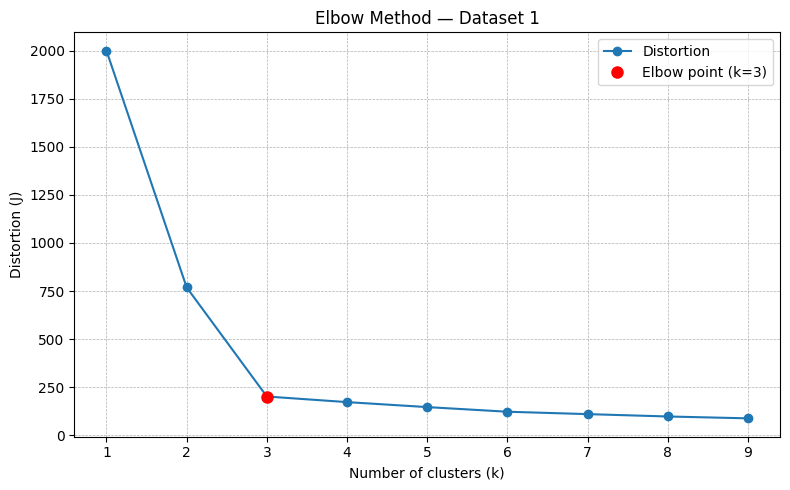

Optimal k = 3, distortion = 201.6019


In [18]:
best_result_d1 = plot_elbow(results_d1, dataset_name="Dataset 1")

In [19]:
best_k_d1 = best_result_d1['k']

Run your algorithm with the dataset 1.

In [20]:
best_codebook_d1, best_labels_d1, best_convergence_d1, best_distortion_d1, convergences_d1 = (
    kmeans_algorithm_multiple_runs(
        data1, 
        k=best_k_d1, 
        n_runs=20, 
        track_convergence=True
    )
)

Visualize your convergence criteria over the epochs using the dataset 1.

In [21]:
def analyze_convergences(convergences, dataset_name="Dataset"):
    """
    Analyze convergence behavior across multiple K-Means runs.

    Selects:
      - The best-quality run (minimum distortion)
      - The fastest run (fewest epochs)

    Plots the convergence curve of the best-quality run.
    """
    distortions = [c["distortion"] for c in convergences]
    best_idx = np.argmin(distortions)
    best_run = convergences[best_idx]

    epochs_per_run = [len(c["convergence"]) for c in convergences]
    fastest_idx = np.argmin(epochs_per_run)
    fastest_run = convergences[fastest_idx]

    epochs = np.arange(1, len(best_run["convergence"]) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, best_run["convergence"], color="tab:blue", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Convergence criterion")
    plt.title(f"Best-quality run (Run {best_run['run']}) - {dataset_name}")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    print(f"Best-quality run index: {best_run['run']}")
    print(f"Distortion: {distortions[best_idx]:.4f}")
    print(f"Fastest run index: {fastest_run['run']} | Epochs: {len(fastest_run['convergence'])}")

    return best_run, fastest_run


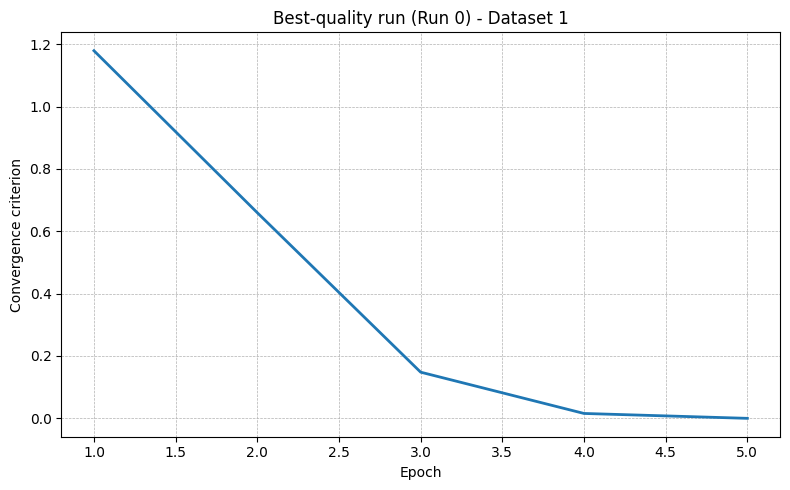

Best-quality run index: 0
Distortion: 201.6019
Fastest run index: 5 | Epochs: 4


In [22]:
best_run_quality_d1, fastest_run_d1 = analyze_convergences(convergences_d1, "Dataset 1")

Visualize the output of your $k$-means on the dataset 1.

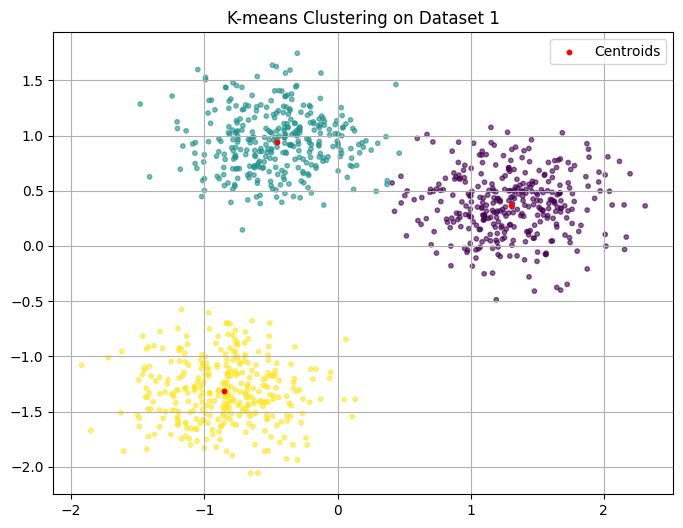

In [23]:
# Your code here
plt.figure(figsize=(8, 6))
plt.scatter(data1[:, 0], data1[:, 1], c=best_labels_d1, s=10, alpha=0.6)
plt.scatter(best_codebook_d1[:, 0], best_codebook_d1[:, 1], c='red', marker='o', s=10, label='Centroids')
plt.title('K-means Clustering on Dataset 1')
plt.legend()
plt.grid()
plt.show()


Do you experience sensitivity to the initial values of the centroids? Is your strategy for initialization working well in most cases?

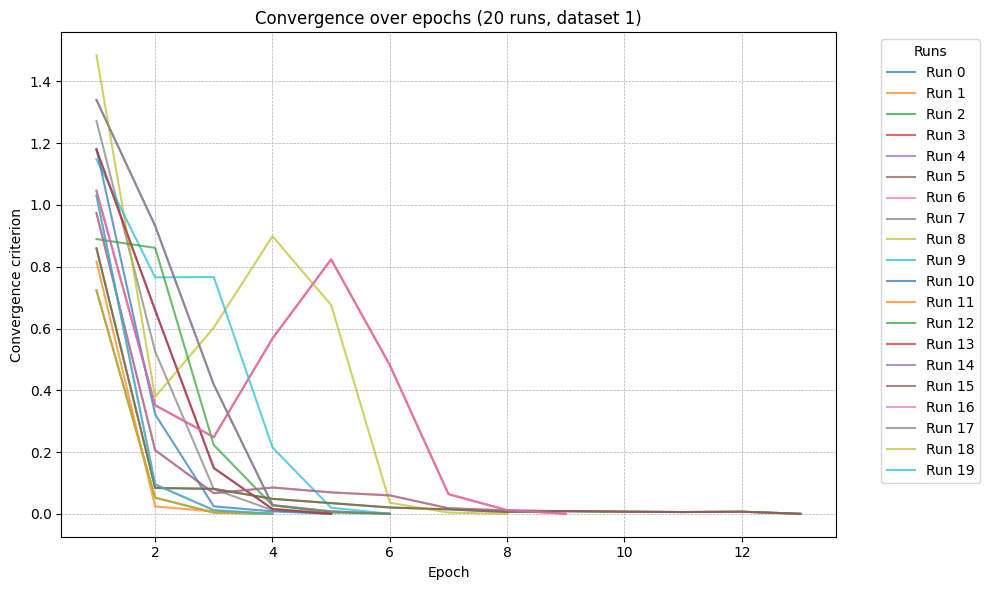

In [24]:
plt.figure(figsize=(10, 6))

for c in convergences_d1:
    epochs = np.arange(1, len(c['convergence']) + 1)
    plt.plot(
        epochs,
        c['convergence'],
        alpha=0.7,
        label=f'Run {c["run"]}'
    )

plt.xlabel('Epoch')
plt.ylabel('Convergence criterion')
plt.title('Convergence over epochs (20 runs, dataset 1)')
plt.legend(title='Runs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [25]:
epochs_per_run_d1 = [len(c['convergence']) for c in convergences_d1]

mean_epochs_d1 = np.mean(epochs_per_run_d1)
std_epochs_d1 = np.std(epochs_per_run_d1)
min_epochs_run_d1 = np.argmin(epochs_per_run_d1)
num_epochs_min_d1 = epochs_per_run_d1[min_epochs_run_d1]
max_epochs_run_d1 = np.argmax(epochs_per_run_d1)
num_epochs_max_d1 = epochs_per_run_d1[max_epochs_run_d1]

print(f"Mean epochs to convergence per run: {mean_epochs_d1:.2f}")
print(f"Std of epochs to convergence per run: {std_epochs_d1:.2f}")
print(f"Run number with min epochs to convergence: {min_epochs_run_d1}")
print(f"Number of epochs of the run with min epochs to convergence: {num_epochs_min_d1}")
print(f"Run number with max epochs to convergence: {max_epochs_run_d1}")
print(f"Number of epochs of the run with max epochs to convergence: {num_epochs_max_d1}")



Mean epochs to convergence per run: 7.10
Std of epochs to convergence per run: 3.30
Run number with min epochs to convergence: 5
Number of epochs of the run with min epochs to convergence: 4
Run number with max epochs to convergence: 1
Number of epochs of the run with max epochs to convergence: 13


The results show a moderate sensitivity to the initial centroid placement, but overall convergence remains stable and reliable across runs.
The average number of epochs to convergence is around 6, with noticeable variability (standard deviation around 2-3). This indicates that random initialization influences how quickly the algorithm stabilizes, as each run starts from a different configuration of centroids.

Some runs converge in as few as four epochs, while others require up to thirteen iterations before satisfying the convergence criterion. This difference reflects how certain initializations place centroids closer to the true cluster centers, allowing faster convergence, whereas others require more updates to reach equilibrium.

The convergence curves clearly illustrate this behavior: most runs exhibit a rapid decrease in the convergence criterion during the first iterations, followed by a plateau as the centroids stabilize. A few runs display small oscillations before reaching the tolerance threshold, which may result from small fluctuations in point assignments near cluster boundaries.

Despite this variability, all runs converge within a limited number of iterations, confirming that the implementation behaves as expected and that the algorithm reliably minimizes the distortion J even under different initial conditions.

Document your convergence criteria. Could you think about other convergence criteria?

Our implementation currently relies on the centroid displacement criterion to detect convergence. However, we could instead use the same criterion as in gradient descent, which monitors the relative decrease of the cost function (distortion) between consecutive epochs: $\frac{J^{(t-1)} - J^{(t)}}{J^{(t)}} < \varepsilon$


This would make the stopping condition directly dependent on the improvement of the objective function rather than the geometric stability of the centroids.


### Dataset 2 - Elbow selection

In [26]:
results_d2 = evaluate_kmeans_elbow(data2, ks=range(1, 10), n_runs=20)

Testing k = 1 ...
Testing k = 2 ...
Testing k = 3 ...
Testing k = 4 ...
Testing k = 5 ...
Testing k = 6 ...
Testing k = 7 ...
Testing k = 8 ...
Testing k = 9 ...


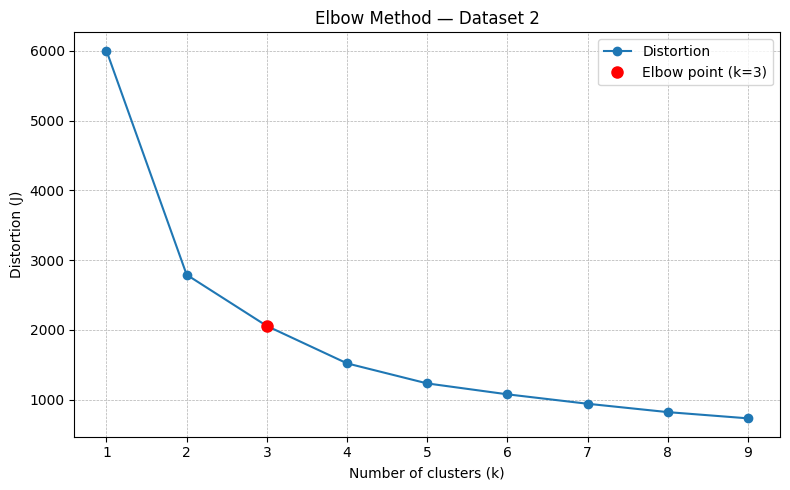

Optimal k = 3, distortion = 2057.4276


In [27]:
best_result_d2 = plot_elbow(results_d2, dataset_name="Dataset 2")

In [28]:
best_k_d2 = best_result_d2["k"]
print(f"Best k (elbow) for Dataset 2: {best_k_d2}")

Best k (elbow) for Dataset 2: 3


Run your algorithm with the dataset 2.

In [29]:
best_codebook_d2, best_labels_d2, best_convergence_d2, best_distortion_d2, convergences_d2 = (
    kmeans_algorithm_multiple_runs(
        data2,
        k=best_k_d2,
        n_runs=20,
        track_convergence=True
    )
)

Visualize your convergence criteria over time using the dataset 2.

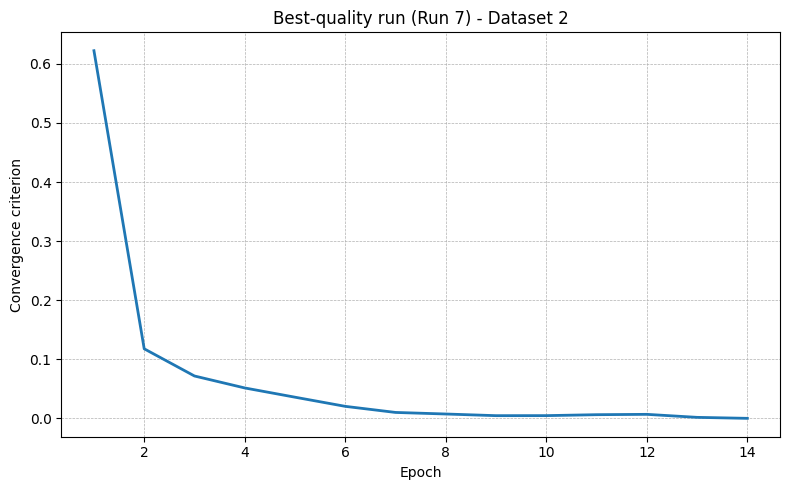

Best-quality run index: 7
Distortion: 2057.4276
Fastest run index: 7 | Epochs: 14


In [30]:
best_run_quality_d2, fastest_run_d2 = analyze_convergences(convergences_d2, "Dataset 2")

Visualize the output of your $k$-means on the dataset 2 and comment your results.

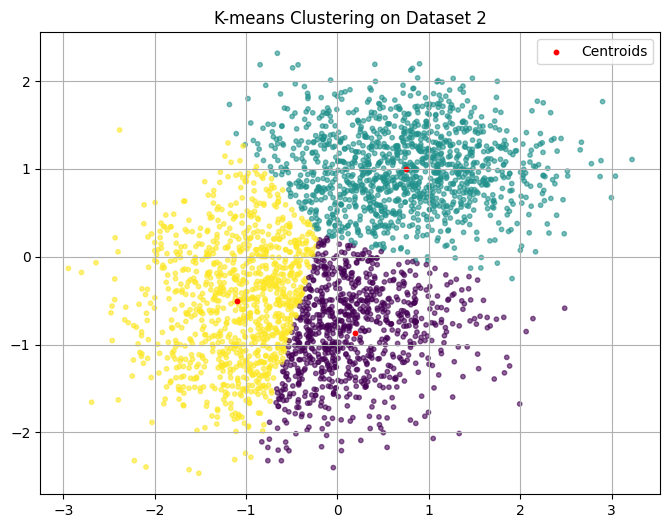

In [31]:
# Your code here
plt.figure(figsize=(8, 6))
plt.scatter(data2[:, 0], data2[:, 1], c=best_labels_d2, s=10, alpha=0.6)
plt.scatter(best_codebook_d2[:, 0], best_codebook_d2[:, 1], c='red', marker='o', s=10, label='Centroids')
plt.title('K-means Clustering on Dataset 2')
plt.legend()
plt.grid()
plt.show()


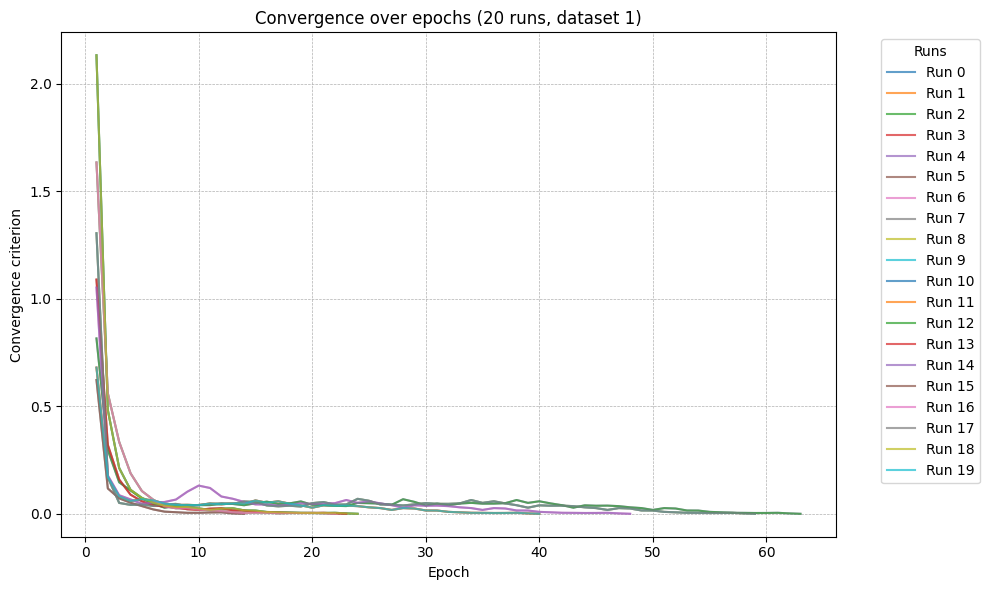

In [32]:
plt.figure(figsize=(10, 6))

for c in convergences_d2:
    epochs = np.arange(1, len(c['convergence']) + 1)
    plt.plot(
        epochs,
        c['convergence'],
        alpha=0.7,
        label=f'Run {c["run"]}'
    )

plt.xlabel('Epoch')
plt.ylabel('Convergence criterion')
plt.title('Convergence over epochs (20 runs, dataset 1)')
plt.legend(title='Runs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Seen that the best k for dataset 2 is 3. Let's see what happens with k=5 (wich is the true number of clusters).

In [33]:
best_codebook_d2_k5, best_labels_d2_k5, best_convergence_d2_k5, best_distortion_d2_k5, convergences_d2_k5 = (
    kmeans_algorithm_multiple_runs(
        data2,
        k=5,
        n_runs=20,
        track_convergence=True
    )
)

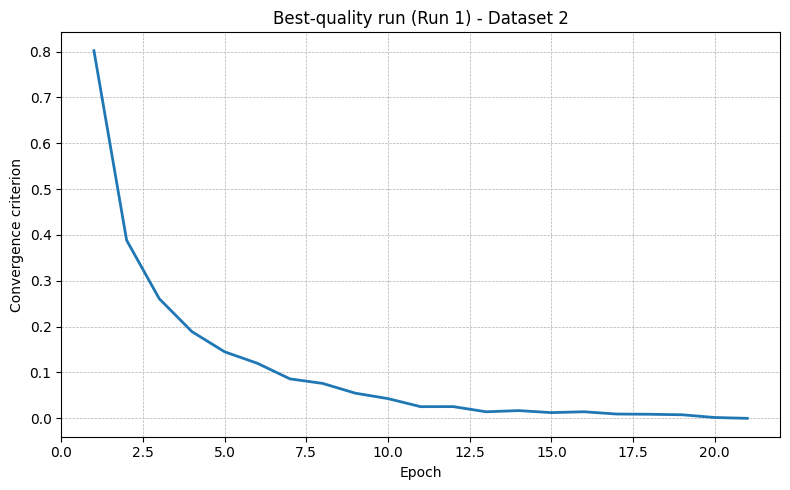

Best-quality run index: 1
Distortion: 1234.4212
Fastest run index: 2 | Epochs: 15


In [34]:
best_run_quality_d2, fastest_run_d2 = analyze_convergences(convergences_d2_k5, "Dataset 2")

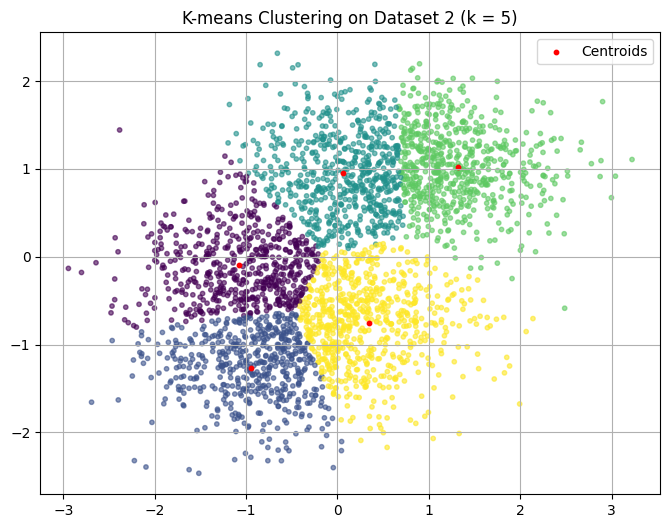

In [35]:
# Your code here
plt.figure(figsize=(8, 6))
plt.scatter(data2[:, 0], data2[:, 1], c=best_labels_d2_k5, s=10, alpha=0.6)
plt.scatter(best_codebook_d2_k5[:, 0], best_codebook_d2_k5[:, 1], c='red', marker='o', s=10, label='Centroids')
plt.title('K-means Clustering on Dataset 2 (k = 5)')
plt.legend()
plt.grid()
plt.show()


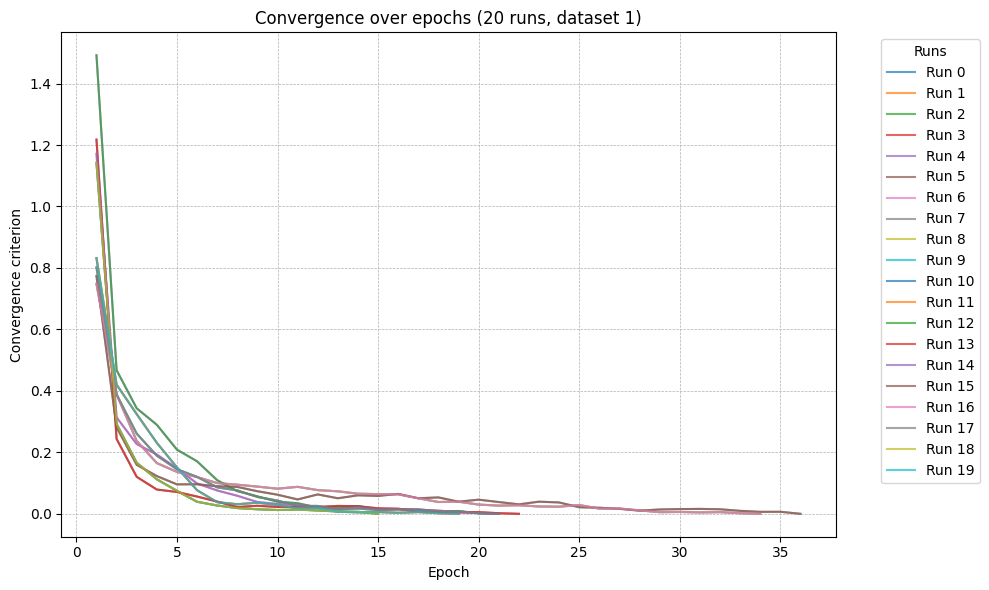

In [36]:
plt.figure(figsize=(10, 6))

for c in convergences_d2_k5[:20]:
    epochs = np.arange(1, len(c['convergence']) + 1)
    plt.plot(
        epochs,
        c['convergence'],
        alpha=0.7,
        label=f'Run {c["run"]}'
    )

plt.xlabel('Epoch')
plt.ylabel('Convergence criterion')
plt.title('Convergence over epochs (20 runs, dataset 1)')
plt.legend(title='Runs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

The elbow method suggested k = 3 as the optimal number of clusters for Dataset 2.
This result can be explained by the high density and overlap between the clusters in this dataset. When clusters are close to each other, increasing the number of centroids beyond a certain point (k = 3) only slightly reduces the distortion (J).

In other words, after k = 3, the decrease in distortion becomes very small, which is why the elbow method identifies this value as the “optimal” trade-off between model simplicity and reconstruction accuracy. However, we know that the dataset was originally generated with five real clusters (k = 5). The fact that the elbow method underestimates this number illustrates its limitations when the data distributions are dense or overlapping: the algorithm merges nearby clusters because the reduction in distortion is not significant enough to justify additional centroids.

When comparing the K-Means clustering results (k = 5) with the true labels of Dataset 2, we can observe clear differences in the cluster assignments. Although the algorithm successfully identifies five groups, the resulting clusters do not perfectly align with the true data structure. This discrepancy is due again to the high density and strong overlap between the underlying Gaussian distributions.

## Exercise 4 - Optional : compare your implementation with the one of scikit-learn

Visit the page of sci-kit learn related to the K-Means algorithm and analyse the API :
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. Realise some experiments with this implementation and compare the results with the ones of your
own implementation. What are your observations ?

In [37]:
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def compare_distortion(data, k_values):
    custom_results = []
    sklearn_results = []

    for k in k_values:
        codebook, labels, _, best_distortion, _ = kmeans_algorithm_multiple_runs(
            data, k=k, n_runs=10, track_convergence=False
        )
        custom_results.append(best_distortion)

        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(data)
        sklearn_results.append(kmeans.inertia_)  # inertia = distortion J

        print(f"k={k}: custom={best_distortion:.2f}, sklearn={kmeans.inertia_:.2f}")

    plt.figure(figsize=(6,4))
    plt.plot(k_values, custom_results, marker='o', label="Custom K-Means")
    plt.plot(k_values, sklearn_results, marker='x', label="Scikit-Learn K-Means")
    plt.title("Méthode du coude - Distortion J")
    plt.xlabel("k (nombre de clusters)")
    plt.ylabel("Distortion J")
    plt.legend()
    plt.tight_layout()
    plt.show()


k=2: custom=769.00, sklearn=769.00
k=3: custom=201.60, sklearn=201.60
k=4: custom=172.46, sklearn=172.46
k=5: custom=146.61, sklearn=146.57
k=6: custom=122.48, sklearn=122.47
k=7: custom=110.35, sklearn=109.84
k=8: custom=97.79, sklearn=97.85


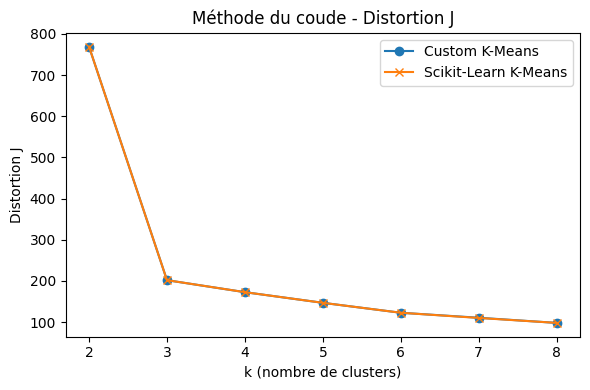

In [39]:
compare_distortion(data1, range(2, 9))

k=2: custom=2790.82, sklearn=2790.84
k=3: custom=2057.43, sklearn=2057.45
k=4: custom=1521.78, sklearn=1521.80
k=5: custom=1234.42, sklearn=1234.44
k=6: custom=1078.28, sklearn=1079.02
k=7: custom=943.10, sklearn=942.61
k=8: custom=823.45, sklearn=823.47


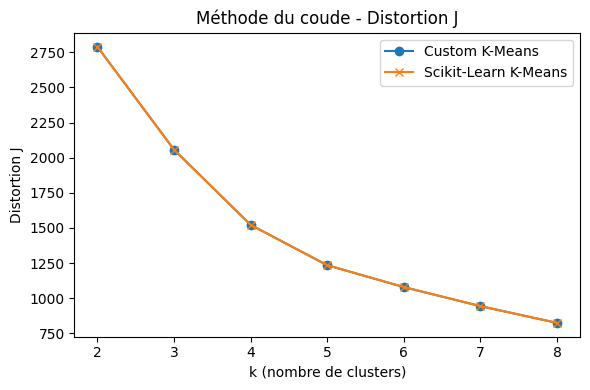

In [40]:
compare_distortion(data2, range(2, 9))

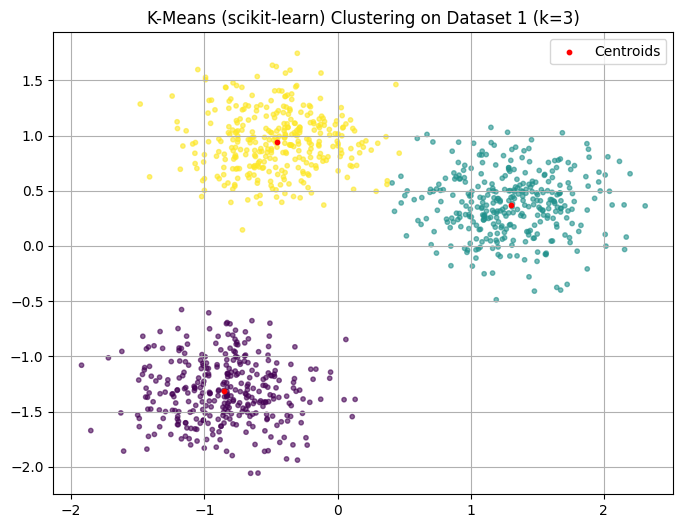

In [41]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

best_k_d1_sklearn = 3
kmeans_best_d1 = KMeans(n_clusters=best_k_d1_sklearn, n_init=20, random_state=42)
kmeans_best_d1.fit(data1)

plt.figure(figsize=(8, 6))
plt.scatter(data1[:, 0], data1[:, 1], c=kmeans_best_d1.labels_, s=10, alpha=0.6)
plt.scatter(kmeans_best_d1.cluster_centers_[:, 0],
            kmeans_best_d1.cluster_centers_[:, 1],
            c='red', marker='o', s=10, label='Centroids')
plt.title(f'K-Means (scikit-learn) Clustering on Dataset 1 (k={best_k_d1_sklearn})')
plt.legend()
plt.grid()
plt.show()


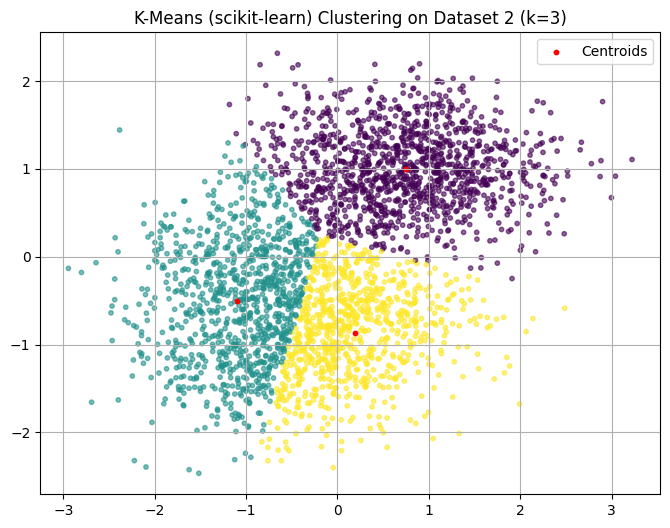

In [42]:
k_d2_sklearn = 3
kmeans_best_d2 = KMeans(n_clusters=k_d2_sklearn, n_init=20, random_state=42)
kmeans_best_d2.fit(data2)

plt.figure(figsize=(8, 6))
plt.scatter(data2[:, 0], data2[:, 1], c=kmeans_best_d2.labels_, s=10, alpha=0.6)
plt.scatter(kmeans_best_d2.cluster_centers_[:, 0],
            kmeans_best_d2.cluster_centers_[:, 1],
            c='red', marker='o', s=10, label='Centroids')
plt.title(f'K-Means (scikit-learn) Clustering on Dataset 2 (k={k_d2_sklearn})')
plt.legend()
plt.grid()
plt.show()

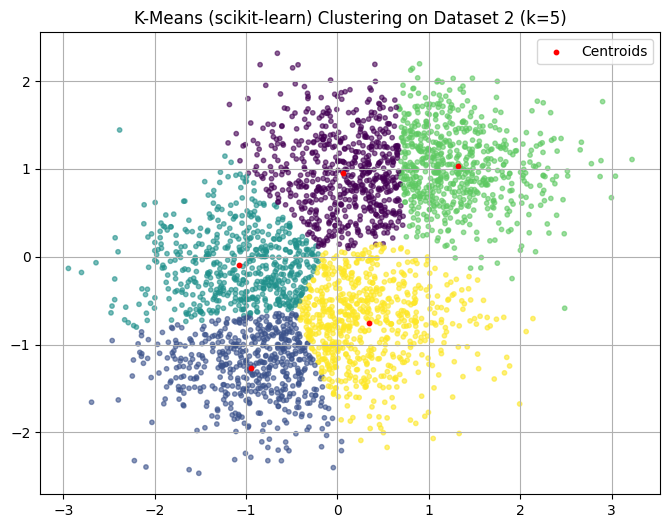

In [43]:
k_d2_sklearn = 5
kmeans_best_d2 = KMeans(n_clusters=k_d2_sklearn, n_init=20, random_state=42)
kmeans_best_d2.fit(data2)

plt.figure(figsize=(8, 6))
plt.scatter(data2[:, 0], data2[:, 1], c=kmeans_best_d2.labels_, s=10, alpha=0.6)
plt.scatter(kmeans_best_d2.cluster_centers_[:, 0],
            kmeans_best_d2.cluster_centers_[:, 1],
            c='red', marker='o', s=10, label='Centroids')
plt.title(f'K-Means (scikit-learn) Clustering on Dataset 2 (k={k_d2_sklearn})')
plt.legend()
plt.grid()
plt.show()

In [44]:
def compare_cluster_sizes(data, k, n_runs=10):
    _, labels_custom, _, _, _ = kmeans_algorithm_multiple_runs(
        data, k=k, n_runs=n_runs, track_convergence=True
    )

    kmeans = KMeans(n_clusters=k, n_init=n_runs, random_state=42)
    kmeans.fit(data)
    labels_sklearn = kmeans.labels_

    counts_custom = Counter(labels_custom)
    counts_sklearn = Counter(labels_sklearn)

    print(f"\nCluster sizes comparison (k={k}):")
    print("Custom:", dict(counts_custom))
    print("Sklearn:", dict(counts_sklearn))

    sizes_custom = sorted(counts_custom.values())
    sizes_sklearn = sorted(counts_sklearn.values())

    if np.allclose(sizes_custom, sizes_sklearn):
        print("The number of samples per cluster is identical")
    else:
        print("Slight difference in cluster sizes.")

compare_cluster_sizes(data1, k=3, n_runs=20)
compare_cluster_sizes(data2, k=5, n_runs=20)


Cluster sizes comparison (k=3):
Custom: {np.int64(2): 335, np.int64(1): 333, np.int64(0): 332}
Sklearn: {np.int32(1): 335, np.int32(0): 333, np.int32(2): 332}
The number of samples per cluster is identical

Cluster sizes comparison (k=5):
Custom: {np.int64(2): 631, np.int64(0): 552, np.int64(1): 611, np.int64(3): 676, np.int64(4): 530}
Sklearn: {np.int32(3): 632, np.int32(2): 552, np.int32(0): 611, np.int32(4): 675, np.int32(1): 530}
Slight difference in cluster sizes.


For both datasets, the distortion values (J) obtained for each number of clusters k are almost identical. In many cases, the values are exactly the same (for example, k=3 on dataset 1), which indicates that both algorithms converged to the same centroids. When small numerical differences appear (e.g. k=7), they are minimal and can be explained by random initialisation and floating-point precision.

Visually, the cluster plots produced by both implementations are indistinguishable. The centroids and the cluster boundaries overlap almost perfectly, confirming that the two algorithms partition the data in the same way. Minor discrepancies may occur when each algorithm converges to a slightly different local minimum, but the global structure remains identical.